# Setup

In [1]:
!pip install segmentation_models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive

drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [3]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
import os
import numpy as np

from keras.models import Sequential, model_from_json
import keras.backend as K
from tensorflow.keras.preprocessing.image import load_img


import matplotlib.pyplot as plt

In [5]:
import shutil
import keras

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

# Load Model

In [8]:
import segmentation_models as sm
sm.set_framework('tf.keras')
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

Segmentation Models: using `keras` framework.


In [9]:
path_to_load_json = '/content/gdrive/MyDrive/Omdena/OpenCities/unet_baseline/model_unet.json'
path_to_load_model = '/content/gdrive/MyDrive/Omdena/OpenCities/unet_baseline/model_unet.h5'

In [10]:
# load json and create model
json_file = open(path_to_load_json, 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights(path_to_load_model)
print("Loaded model from disk")

Loaded model from disk


In [11]:
num_layers = len(model.layers)
to_freeze = int(0.6*num_layers)

In [12]:
for i in range(to_freeze): 
  model.layers[i].trainable  = False 

for layer in model.layers:
  print(layer.trainable) 

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
T

# Load Data

In [13]:
IMAGE_SIZE = 256

def open_images(paths, is_mask=False):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        if is_mask:
          image = np.mean(image, axis=-1)/255.0
        else:
          image = np.array(image)/255.0
        images.append(image)
    return np.array(images)

In [14]:
def get_image_paths(path, images=True) -> list:
    """Returns a list of image or masks paths from a folder"""
    paths = [path + fname for fname in os.listdir(path)]
    to_return = []
    if images:
        png_images = []
        for image in paths:
            if image.endswith(".tif"):
                png_images.append(image)
        to_return = png_images
    else:
        to_return = paths
    return sorted(to_return)

In [15]:
images_1 = "/content/gdrive/MyDrive/Omdena/data/images_v2/3/"
image_paths = get_image_paths(images_1)
masks_1 = "/content/gdrive/MyDrive/Omdena/data/masks_v2/3/"
masks_paths = get_image_paths(masks_1)

In [16]:
image_paths[:5]

['/content/gdrive/MyDrive/Omdena/data/images_v2/2/OAM-1238424-1046544-21.tif',
 '/content/gdrive/MyDrive/Omdena/data/images_v2/2/OAM-1238424-1046545-21.tif',
 '/content/gdrive/MyDrive/Omdena/data/images_v2/2/OAM-1238424-1046546-21.tif',
 '/content/gdrive/MyDrive/Omdena/data/images_v2/2/OAM-1238424-1046547-21.tif',
 '/content/gdrive/MyDrive/Omdena/data/images_v2/2/OAM-1238425-1046544-21.tif']

In [17]:
masks_paths[:5]

['/content/gdrive/MyDrive/Omdena/data/masks_v2/2/OAM-1238424-1046544-21.tif',
 '/content/gdrive/MyDrive/Omdena/data/masks_v2/2/OAM-1238424-1046545-21.tif',
 '/content/gdrive/MyDrive/Omdena/data/masks_v2/2/OAM-1238424-1046546-21.tif',
 '/content/gdrive/MyDrive/Omdena/data/masks_v2/2/OAM-1238424-1046547-21.tif',
 '/content/gdrive/MyDrive/Omdena/data/masks_v2/2/OAM-1238425-1046544-21.tif']

In [18]:
all_images = open_images(image_paths, is_mask=False)
all_masks = open_images(masks_paths, is_mask=True)

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    all_images,
    all_masks,
    test_size=0.25,
    random_state=0,
)

In [20]:
import gc 
del all_images 
del all_masks 
gc.collect()

385

In [21]:
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

In [22]:
model.compile(keras.optimizers.Adam(learning_rate=1e-4),
    loss=sm.losses.dice_loss,
    metrics=[sm.metrics.iou_score])

In [23]:
history = model.fit(
    X_train, y_train, validation_data=[X_test, y_test], batch_size=16, epochs=30
)

Epoch 1/30
7/7 [==============================] - 16s 1s/step - loss: 0.2453 - iou_score: 0.6075 - val_loss: 0.1923 - val_iou_score: 0.6629
Epoch 2/30
7/7 [==============================] - 1s 207ms/step - loss: 0.2256 - iou_score: 0.6330 - val_loss: 0.1884 - val_iou_score: 0.6689
Epoch 3/30
7/7 [==============================] - 1s 207ms/step - loss: 0.2225 - iou_score: 0.6380 - val_loss: 0.1859 - val_iou_score: 0.6730
Epoch 4/30
7/7 [==============================] - 2s 230ms/step - loss: 0.2127 - iou_score: 0.6509 - val_loss: 0.1833 - val_iou_score: 0.6761
Epoch 5/30
7/7 [==============================] - 2s 230ms/step - loss: 0.2051 - iou_score: 0.6611 - val_loss: 0.1802 - val_iou_score: 0.6796
Epoch 6/30
7/7 [==============================] - 2s 230ms/step - loss: 0.1945 - iou_score: 0.6768 - val_loss: 0.1767 - val_iou_score: 0.6836
Epoch 7/30
7/7 [==============================] - 1s 208ms/step - loss: 0.1981 - iou_score: 0.6711 - val_loss: 0.1737 - val_iou_score: 0.6873
Epoch 8/

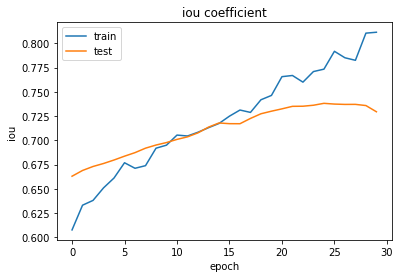

In [24]:
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('iou coefficient')
plt.ylabel('iou')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [25]:
def test_prediction(image, true_mask):
  HOT_test_img = preprocess_input(np.array([image]))
  pred_mask = model.predict(HOT_test_img)

  fig = plt.figure(figsize=(10, 5))
  fig.add_subplot(1,3,1)
  plt.title('image')
  plt.imshow(image)
  fig.add_subplot(1,3,2)
  plt.title('true mask')
  plt.imshow(true_mask.reshape((256,256)), cmap='gray')
  fig.add_subplot(1,3,3)
  plt.title('pred mask')
  plt.imshow(pred_mask[0].reshape((256,256)), cmap='gray')

  plt.axis('off')
  plt.show()

1/1 [==============================] - 1s 1s/step


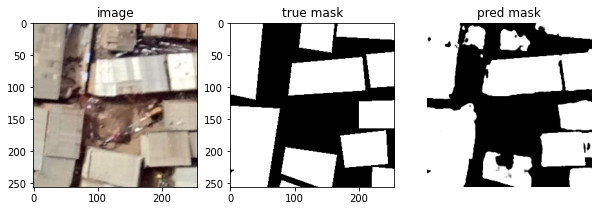

In [26]:
test_prediction(X_test[0], y_test[0])